# Doppler Image Segmentation 
## Lab 2, Applied Machine Learning

**Pierre Le Fevre, VT 2022**

---

## Import images
There are 153 expert masks, where they generally map to both "H" (noisy) and "O" (clean) images. Both are added with the matching mask to the arrays to ensure that the model has many different types to train on.


In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import * 
from keras.layers import *
from keras.optimizers import *
import keras.backend as K
import matplotlib.pyplot as plt
from random import shuffle
from tensorflow import keras

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
FILEPATH = '/content/drive/MyDrive/ML_Data/Doppler/'
SIZE = 128

def load_masked_images():
    raw_images = []
    mask_images = []
    
    for mask_filename in sorted(os.listdir(os.path.join(FILEPATH, "mask"))):
        raw_filename = mask_filename.replace("M", "") #Raw file with "o" in filepath, less noise
        raw_h_filename = raw_filename.replace("O", "H") #Raw file with "h" in filepath, more noise
        
        
        raw_img = cv2.imread(os.path.join(FILEPATH, "raw", raw_filename), 0)
        raw_h_img = cv2.imread(os.path.join(FILEPATH, "raw", raw_h_filename), 0)
        mask_img = cv2.imread(os.path.join(FILEPATH, "mask", mask_filename), 0)

        if raw_img is not None and mask_img is not None:
            raw_images.append(cv2.resize(raw_img, (SIZE, SIZE)))
            mask_images.append(cv2.resize(mask_img, (SIZE, SIZE)))
        if raw_h_img is not None and mask_img is not None:
            raw_images.append(cv2.resize(raw_h_img, (SIZE, SIZE)))
            mask_images.append(cv2.resize(mask_img, (SIZE, SIZE)))

    return raw_images, mask_images

def load_all_images():
    images = []
    folder="raw"
    
    for filename in sorted(os.listdir(os.path.join(FILEPATH, folder))):   
        # Check if file has a corresponding mask   
        if filename.replace("O", "OM").replace("H", "OM") in os.listdir(os.path.join(FILEPATH, "mask")):
          continue

        img = cv2.imread(os.path.join(FILEPATH, folder,filename), 0)

        if img is not None:
            images.append(cv2.resize(img, (SIZE, SIZE)))
    return images

all_images = load_all_images()
raw_images, mask_images = load_masked_images()

In [ ]:
print(len(raw_images))
print(len(mask_images))
print(len(all_images))

304
304
108


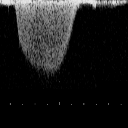

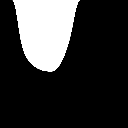

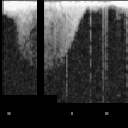

In [ ]:
cv2_imshow(raw_images[0])
cv2_imshow(mask_images[0])
cv2_imshow(all_images[0])

In [ ]:
print('mask shape', np.array(mask_images).shape)
print('raw shape', np.array(raw_images).shape)

mask shape (304, 128, 128)
raw shape (304, 128, 128)


## Normalize values

Values need to be normalized to make weight differences as small as possible.

In [ ]:
# Shape as numpy arrays
mask_images = np.array(mask_images).reshape(np.array(mask_images).shape[0], SIZE, SIZE, 1)
raw_images = np.array(raw_images).reshape(np.array(raw_images).shape[0], SIZE, SIZE, 1)
all_images = np.array(all_images).reshape(np.array(all_images).shape[0], SIZE, SIZE, 1)

# Make the arrays into float arrays so that values are preserved
mask_images = mask_images.astype('float32')
raw_images = raw_images.astype('float32')
all_images = all_images.astype('float32')

# Normalize images
mask_images /= 255
raw_images /= 255
all_images /= 255

## Prepare for NN
GPU presence is verified as training the model is essentially impossible without one.

In [ ]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## CNN (UNet)

This neural network is shaped as a UNet, where inputs are images at 128*128 px.
Dropout and batch normalizers were tried to improve overfitting but results were of dubious improvement. 

Adding layers seemed to improve noise reduction and generated overall more usable images.

In [ ]:
input_size = (SIZE, SIZE, 1)
kernel_size = (3,3)

inputs = Input(input_size)

# 128 -> 64
conv_down_1 = Conv2D(64, kernel_size, activation='relu', padding='same')(inputs)
conv_down_1 = Conv2D(64, kernel_size, activation='relu', padding='same')(conv_down_1)
pool1 = MaxPooling2D((2,2), padding='same')(conv_down_1)

# 64 -> 32
conv_down_2 = Conv2D(128, kernel_size, activation='relu', padding='same')(pool1)
conv_down_2 = Conv2D(128, kernel_size, activation='relu', padding='same')(conv_down_2)
pool2 = MaxPooling2D((2,2), padding='same')(conv_down_2)

# 32 -> 16
conv_down_3 = Conv2D(256, kernel_size, activation='relu', padding='same')(pool2)
conv_down_3 = Conv2D(256, kernel_size, activation='relu', padding='same')(conv_down_3)
pool3 = MaxPooling2D((2,2), padding='same')(conv_down_3)

# 16 -> 8
conv_down_4 = Conv2D(512, kernel_size, activation='relu', padding='same')(pool3)
conv_down_4 = Conv2D(512, kernel_size, activation='relu', padding='same')(conv_down_4)
pool4 = MaxPooling2D((2,2), padding='same')(conv_down_4)

## Bottom of the "U"
bottom = Conv2D(1024, kernel_size, activation='relu', padding='same')(pool4)
bottom = Conv2D(1024, kernel_size, activation='relu', padding='same')(bottom)
## Go back up

# 8 -> 16
merge1 = Concatenate(axis=3)([pool4, bottom])
up1 = UpSampling2D(size=(2,2))(merge1)
conv_up_1 = Conv2D(512, kernel_size, activation='relu', padding='same')(up1)
conv_up_1 = Conv2D(512, kernel_size, activation='relu', padding='same')(conv_up_1)

# 16 -> 32
merge2 = Concatenate(axis=3)([pool3, conv_up_1])
up2 = UpSampling2D(size=(2,2))(merge2)
conv_up_2 = Conv2D(256, kernel_size, activation='relu', padding='same')(up2)
conv_up_2 = Conv2D(256, kernel_size, activation='relu', padding='same')(conv_up_2)

# 32 -> 64
merge3 = Concatenate(axis=3)([pool2, conv_up_2])
up3 = UpSampling2D(size=(2,2))(merge3)
conv_up_3 = Conv2D(128, kernel_size, activation='relu', padding='same')(up3)
conv_up_3 = Conv2D(128, kernel_size, activation='relu', padding='same')(conv_up_3)

# 64 -> 128
merge4 = Concatenate(axis=3)([pool1, conv_up_3])
up4 = UpSampling2D(size=(2,2))(merge4)
conv_up_4 = Conv2D(64, kernel_size, activation='relu', padding='same')(up4)
conv_up_4 = Conv2D(64, kernel_size, activation='relu', padding='same')(conv_up_4)

output = Conv2D(1, (1,1), activation='sigmoid', padding='same')(conv_up_4)

model = Model(inputs, output)

model.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_17 (InputLayer)          [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_327 (Conv2D)            (None, 128, 128, 64  640         ['input_17[0][0]']               
                                )                                                                 
                                                                                                  
 conv2d_328 (Conv2D)            (None, 128, 128, 64  36928       ['conv2d_327[0][0]']             
                                )                                                          

## Compile and train model
The model must now be trained, which can be done using sklearn's `train_test_split`. 
Binary crossentropy was chosen as the task is a binary image segmentation model.

Both "O" (clean) and "H" (noisy) images are used to create a model which can predict a more accurate mask for both types of input.

Epoch 1/11
8/8 [==============================] - 4s 296ms/step - loss: 19.0143 - accuracy: 0.7715 - val_loss: 0.6544 - val_accuracy: 0.6947
Epoch 2/11
8/8 [==============================] - 2s 248ms/step - loss: 0.6304 - accuracy: 0.7696 - val_loss: 0.5396 - val_accuracy: 0.8747
Epoch 3/11
8/8 [==============================] - 2s 229ms/step - loss: 0.4017 - accuracy: 0.8780 - val_loss: 0.2935 - val_accuracy: 0.8614
Epoch 4/11
8/8 [==============================] - 2s 232ms/step - loss: 0.3730 - accuracy: 0.8656 - val_loss: 0.2916 - val_accuracy: 0.8955
Epoch 5/11
8/8 [==============================] - 2s 234ms/step - loss: 0.2214 - accuracy: 0.9132 - val_loss: 0.1477 - val_accuracy: 0.9384
Epoch 6/11
8/8 [==============================] - 2s 230ms/step - loss: 0.1441 - accuracy: 0.9418 - val_loss: 0.1228 - val_accuracy: 0.9497
Epoch 7/11
8/8 [==============================] - 2s 233ms/step - loss: 0.1158 - accuracy: 0.9531 - val_loss: 0.0837 - val_accuracy: 0.9649
Epoch 8/11
8/8 [===

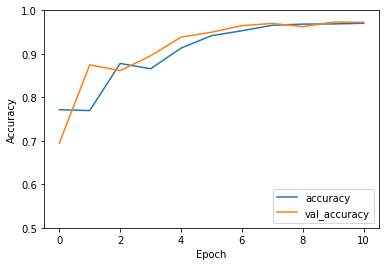

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

from sklearn.model_selection import train_test_split

train_images, test_images, train_masks, test_masks = train_test_split(raw_images, mask_images, test_size=0.2)

history = model.fit(train_images, train_masks, epochs=11, validation_data=(test_images, test_masks))

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images, test_masks, verbose=2)

## Predict against raw images
The now trained model can then be used to predict a mask for all raw images. Both seen and unseen images are predicted.



In [ ]:
# Predict for both seen and unseen images
all_images = np.concatenate((raw_images, all_images))
pred_masks = model.predict(all_images)

(412, 128, 128, 1)


In [ ]:
# De-normalize images
print(pred_masks.shape)
pred_masks*=255
raw_images*=255
mask_images*=255
all_images*=255

## Results

The outputed images from the model are then treated in the following way:


1.   First, the prediction image is thresholded so that only "bright enough" parts are used.
2.   Vmax can then be calculated by scanning the image for the first y-value that has a non null pixel.
3.   After that, some information is added to the images for easier readout.



In [ ]:
from PIL import Image, ImageDraw, ImageFont
from matplotlib import font_manager

vmaxes_from_model = []
bigImage = []
failed = []

for i in range(0, len(all_images)):
  
  # Prepare image data as np arrays
  raw = all_images[i]
  raw = np.array(raw).reshape(SIZE, SIZE, 1)
  thresh = cv2.threshold(np.float32(pred_masks[i]), 116, 255, cv2.THRESH_BINARY)[1]
  raw = np.array(raw).reshape(SIZE, SIZE)
  thresh = np.array(thresh).reshape(SIZE, SIZE)
  pred = np.array(pred_masks[i]).reshape(SIZE, SIZE)
  
  # Calculate vmax
  try:
    vmax_pair = 128 - cv2.findNonZero(cv2.flip(thresh, 0))[0][0]
    vmax = vmax_pair[1]
  except:
    failed.append(i)
    continue
    
  vmaxes_from_model.append(vmax)

  
  # Find the sans-serif system font
  font =  font_manager.FontProperties(family='sans-serif', weight='bold')
  file =  font_manager.findfont(font)
  font =  ImageFont.truetype(file, 15)
  
  # Generate info image
  info =   Image.new('L', (SIZE, SIZE), (82 if i%2==0 else 56))
  indo_d = ImageDraw.Draw(info)
  indo_d.text((5,10), str(i) + "/" + str(len(all_images)), font=font, align ="left", fill=(255))
  indo_d.text((5,60), "Vmax: " + str(vmax), font=font, align ="left", fill=(255))
  if i >= len(raw_images):
    # Mark if this is an unseen image
    indo_d.text((5,90), "*", font=font, align ="left", fill=(255))
  info =  np.array(info).reshape(SIZE, SIZE, 1)

  # Generate raw image
  raw_mod = Image.fromarray(raw)
  raw_d = ImageDraw.Draw(raw_mod)
  raw_d.text((5,110), "Raw", font=font, align ="left", fill=(255))
  raw_mod = np.array(raw_mod).reshape(SIZE, SIZE, 1)
  
  # Generate thresholded prediction image
  thresh_mod = Image.fromarray(thresh)
  thresh_d = ImageDraw.Draw(thresh_mod)
  thresh_d.line([(0,vmax), (SIZE, vmax)], fill ="white", width = 1) 
  thresh_d.text((60,vmax), str(vmax), font=font, align ="left", fill=(255))
  thresh_d.text((5,110), "Predicted", font=font, align ="left", fill=(255))
  thresh_mod = np.array(thresh_mod).reshape(SIZE, SIZE, 1)
  
  # Generate raw prediction image
  pred_mod = Image.fromarray(pred)
  pred_d = ImageDraw.Draw(pred_mod)
  pred_d.text((5,110), "Model", font=font, align ="left", fill=(255))
  pred_mod = np.array(pred_mod).reshape(SIZE, SIZE, 1)
  
  # If there is an expert drawn mask
  if i < len(raw_images):
    
    # Fetch it and add label
    expert = np.array(mask_images[i]).reshape(SIZE, SIZE)
    expert_mod = Image.fromarray(expert)
    expert_d = ImageDraw.Draw(expert_mod)
    expert_d.text((5,110), "Expert", font=font, align ="left", fill=(255))
    expert_mod = np.array(expert_mod).reshape(SIZE, SIZE, 1)
    
    # Assemble the images 
    newImage = np.hstack((info, raw_mod, thresh_mod, pred_mod, expert_mod))

  # Otherwise, just assemble the raw and generated images
  else:
    newImage = np.hstack((info, raw_mod, thresh_mod, pred_mod))
  
  # Draw image (CV2_imshow is for Google Colab, use cv2.imshow otherwise)
  cv2_imshow(newImage)  

if len(failed) > 0:
  print("Images failed: " + str(failed))

## Calculating error
A lot of problems with the model can be found by simply looking at the images above. However, to be able to quantify the amount of error in the model, statistical analysis is needed.
In this case, finding errors through statistical analysis can be done with a Bland-Altman plot

The graph generating function below was fetched from https://stackoverflow.com/a/16401920/8830120

In [ ]:
# Calculate vmaxes from expert masks for comparison
vmaxes_from_masks = []
for i in range(0, len(mask_images)):
  mask = mask_images[i]
  mask = np.array(mask).reshape(SIZE, SIZE, 1)
  vmax = 128 - cv2.findNonZero(cv2.flip(mask, 0))[0][0][1]
  vmaxes_from_masks.append(vmax)

In [ ]:
def bland_altman_plot(data1, data2, *args, **kwargs):
    data1     = np.asarray(data1)
    data2     = np.asarray(data2)
    mean      = np.mean([data1, data2], axis=0)
    diff      = data1 - data2                   # Difference between data1 and data2
    md        = np.mean(diff)                   # Mean of the difference
    sd        = np.std(diff, axis=0)            # Standard deviation of the difference

    plt.scatter(mean, diff, *args, **kwargs)
    plt.axhline(md,           color='gray', linestyle='--')
    plt.axhline(md + 1.96*sd, color='gray', linestyle='--')
    plt.axhline(md - 1.96*sd, color='gray', linestyle='--')
    plt.xlabel("Average of 2 measures")
    plt.ylabel("Difference between 2 measures")

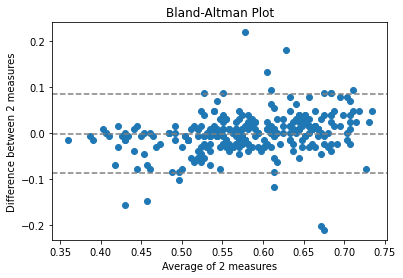

In [ ]:
bland_altman_plot(np.array(vmaxes_from_masks)/SIZE, np.array(vmaxes_from_model[:len(mask_images)])/SIZE)
plt.title('Bland-Altman Plot')
plt.show()

As indicated by the plot above, it seems like the model often overshoots the vmax with most error being within ±20 pixels. Maximum error is around 50 px.
Compared to the [research paper](https://www.ahajournals.org/doi/abs/10.1161/circ.144.suppl_1.10657), it is only 0.1 higher.

Mean error stays under 0.5, which coincides with the paper's findings.

## Conclusion

Since the Doppler signals are often quite noisy, it is important that the model can understand both "O" (clean) and "H" (noisy) types. 

As for the usefullness of such a model, depending on the amount of images generated from the measurement of a single patient, it might be a good idea to double check the values as accuracy only seems to get to about 90%. Even for images which were not used for training, denoted by a `*` in the info panels above, a very accurate vmax can be calculated (See #1 below).

Any bad sensor data does however still generate erroneous data (see #2 below).



### 1.
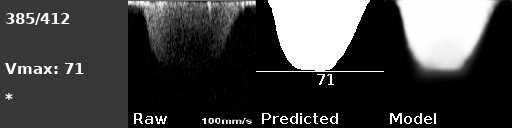

### 2.
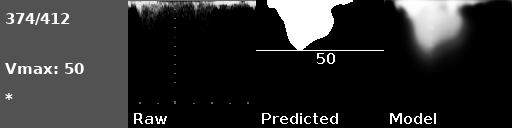

Overall, I think that a model similar to this could be chosen to aid in processing huge amounts of doppler readings. For any readings that could count as "negative" to the patient, the result should obviously be manually checked.

If another model or a manual heuristic could be made to identify which doppler images were simply bad readings, this model could gain quite a lot of reliability as most input data would be very similar.